**다중 테이블 쿼리의 계획 트리를 생성하는 과정을 설명**

# **Preprocessing**

- planner.c 에 정의된 subquery_planner() 함수 는 전처리를 호출합니다.
 - 다중 테이블 쿼리에 대한 전처리에 대해 설명

1. CTE 계획 및 변환
  - WITH 목록이 있는 경우 플래너는 SS_process_ctes() 함수를 통해 각 WITH 쿼리를 처리.

2. Pulling Subqueries Up
  - FROM 절에 하위 쿼리가 있고 GROUP BY, HAVING, ORDER BY, LIMIT 또는 DISTINCT 절이 없고 INTERSECT 또는 EXCEPT를 사용하지 않는 경우 플래너는 pull_up_subqueries() 함수에 의해 조인 형식으로 변환.
  - 예를 들어 FROM 절에 하위 쿼리가 포함된 아래 쿼리를 자연 조인 쿼리로 변환할 수 있음. 이 변환은 쿼리 트리에서 수행.


```
testdb=# SELECT * FROM tbl_a AS a, (SELECT * FROM tbl_b) as b WHERE a.id = b.id;
```

⇓

```
testdb=# SELECT * FROM tbl_a AS a, tbl_b as b WHERE a.id = b.id;
```

3. 외부 조인을 내부 조인으로 변환
  - 플래너는 가능한 경우 외부 조인 쿼리를 내부 조인 쿼리로 변환.

**Getting the Cheapest Path**

- 최적의 계획 트리를 얻으려면 플래너는 인덱스와 조인 방법의 모든 조합을 고려해야 함.
  -  이는 매우 비용이 많이 드는 프로세스이며 조합 폭발로 인해 테이블 ​​수가 일정 수준을 초과하면 실행 불가능.
  - 테이블 수가 12개 정도보다 작을 경우에는 동적 프로그래밍을 적용해 최적의 계획을 세울 수 있음.
  - 그렇지 않으면 플래너는 유전 알고리즘을 사용

- 유전자 쿼리 최적화 프로그램
  - 여러 테이블을 조인하는 쿼리를 실행하는 경우 쿼리 계획을 최적화하는 데 엄청난 시간이 필요
  -  이러한 상황을 처리하기 위해 PostgreSQL은 Genetic Query Optimizer 라는 흥미로운 기능을 구현

- 이는 합리적인 시간 내에 합리적인 계획을 결정하기 위한 일종의 대략적인 알고리즘
- 따라서 쿼리 최적화 단계에서 조인 테이블의 수가 geqo_threshold 매개변수에 지정된 임계값 (기본값은 12)보다 높을 경우 PostgreSQL은 유전 알고리즘을 사용하여 쿼리 계획을 생성.

- 동적 프로그래밍에 의한 최적의 계획 트리 결정은 다음 단계로 설명.

- 레벨 = 1
  - 각 테이블에 대해 가장 저렴한 경로를 가져옴.
  - 가장 저렴한 경로는 해당 RelOptInfo에 저장.

- 레벨 = 2
  - 두 테이블의 각 조합에 대해 가장 저렴한 경로를 얻음.
  - 예를 들어 A와 B라는 두 개의 테이블이 있는 경우 테이블 A와 B의 가장 저렴한 조인 경로를 가져옴. 이것이 최종 답.
  - 다음에서는 두 테이블의 RelOptInfo를 {A, B}로 표현.
  - 테이블이 3개라면 {A, B}, {A, C}, {B, C} 각각에 대해 가장 저렴한 경로를 구함.

- 레벨 = 3 이상
  - 테이블 수와 동일한 레벨에 도달할 때까지 동일한 프로세스를 계속함.

- 이렇게 하면 각 레벨에서 부분 문제의 가장 저렴한 경로를 구하여 상위 레벨의 계산을 얻는 데 사용.
- 이를 통해 가장 저렴한 계획 트리를 효율적으로 계산할 수 있음.



**동적 프로그래밍을 사용하여 가장 저렴한 액세스 경로를 얻는 방법**

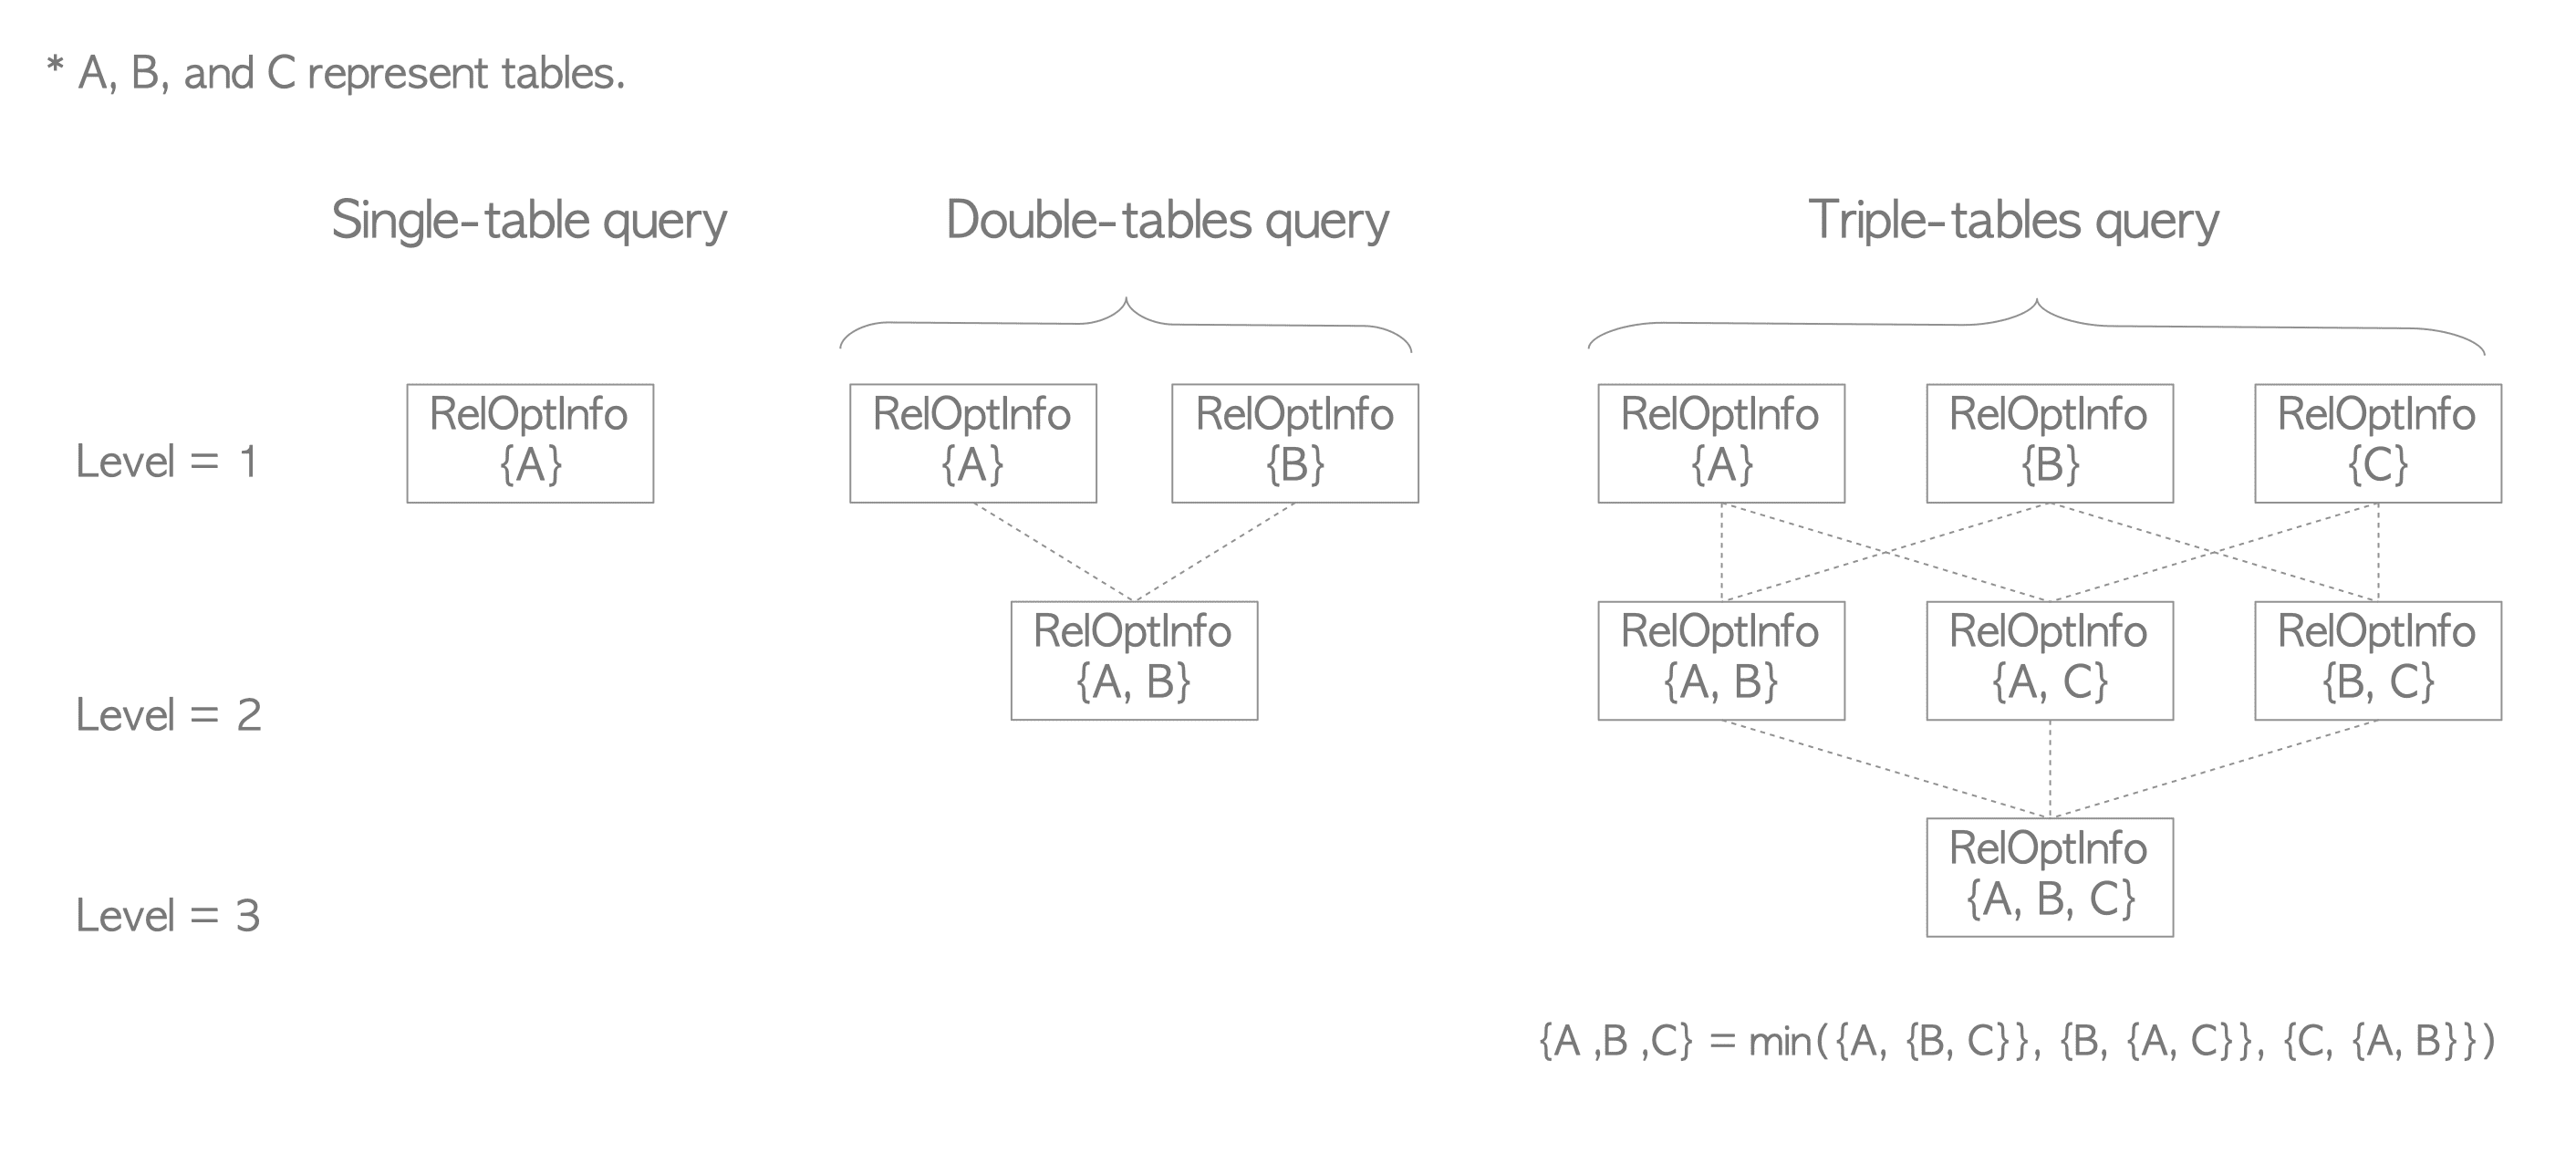

- 다음에서는 Planner가 다음 질의의 가장 저렴한 Plan을 얻는 과정을 설명.




```
testdb=# \d tbl_a
     Table "public.tbl_a"
 Column |  Type   | Modifiers
--------+---------+-----------
 id     | integer | not null
 data   | integer |
Indexes:
    "tbl_a_pkey" PRIMARY KEY, btree (id)

testdb=# \d tbl_b
     Table "public.tbl_b"
 Column |  Type   | Modifiers
--------+---------+-----------
 id     | integer |
 data   | integer |

testdb=# SELECT * FROM tbl_a AS a, tbl_b AS b WHERE a.id = b.id AND b.data < 400;
```

**레벨 1에서 처리**

- 레벨 1에서 플래너는 RelOptInfo 구조를 생성하고 쿼리의 각 관계에 대해 가장 저렴한 비용을 추정.
- RelOptInfo 구조는 이 쿼리의 PlannerInfo의 simple_rel_array에 추가.

**수준 1에서 처리된 후의 PlannerInfo 및 RelOptInfo**

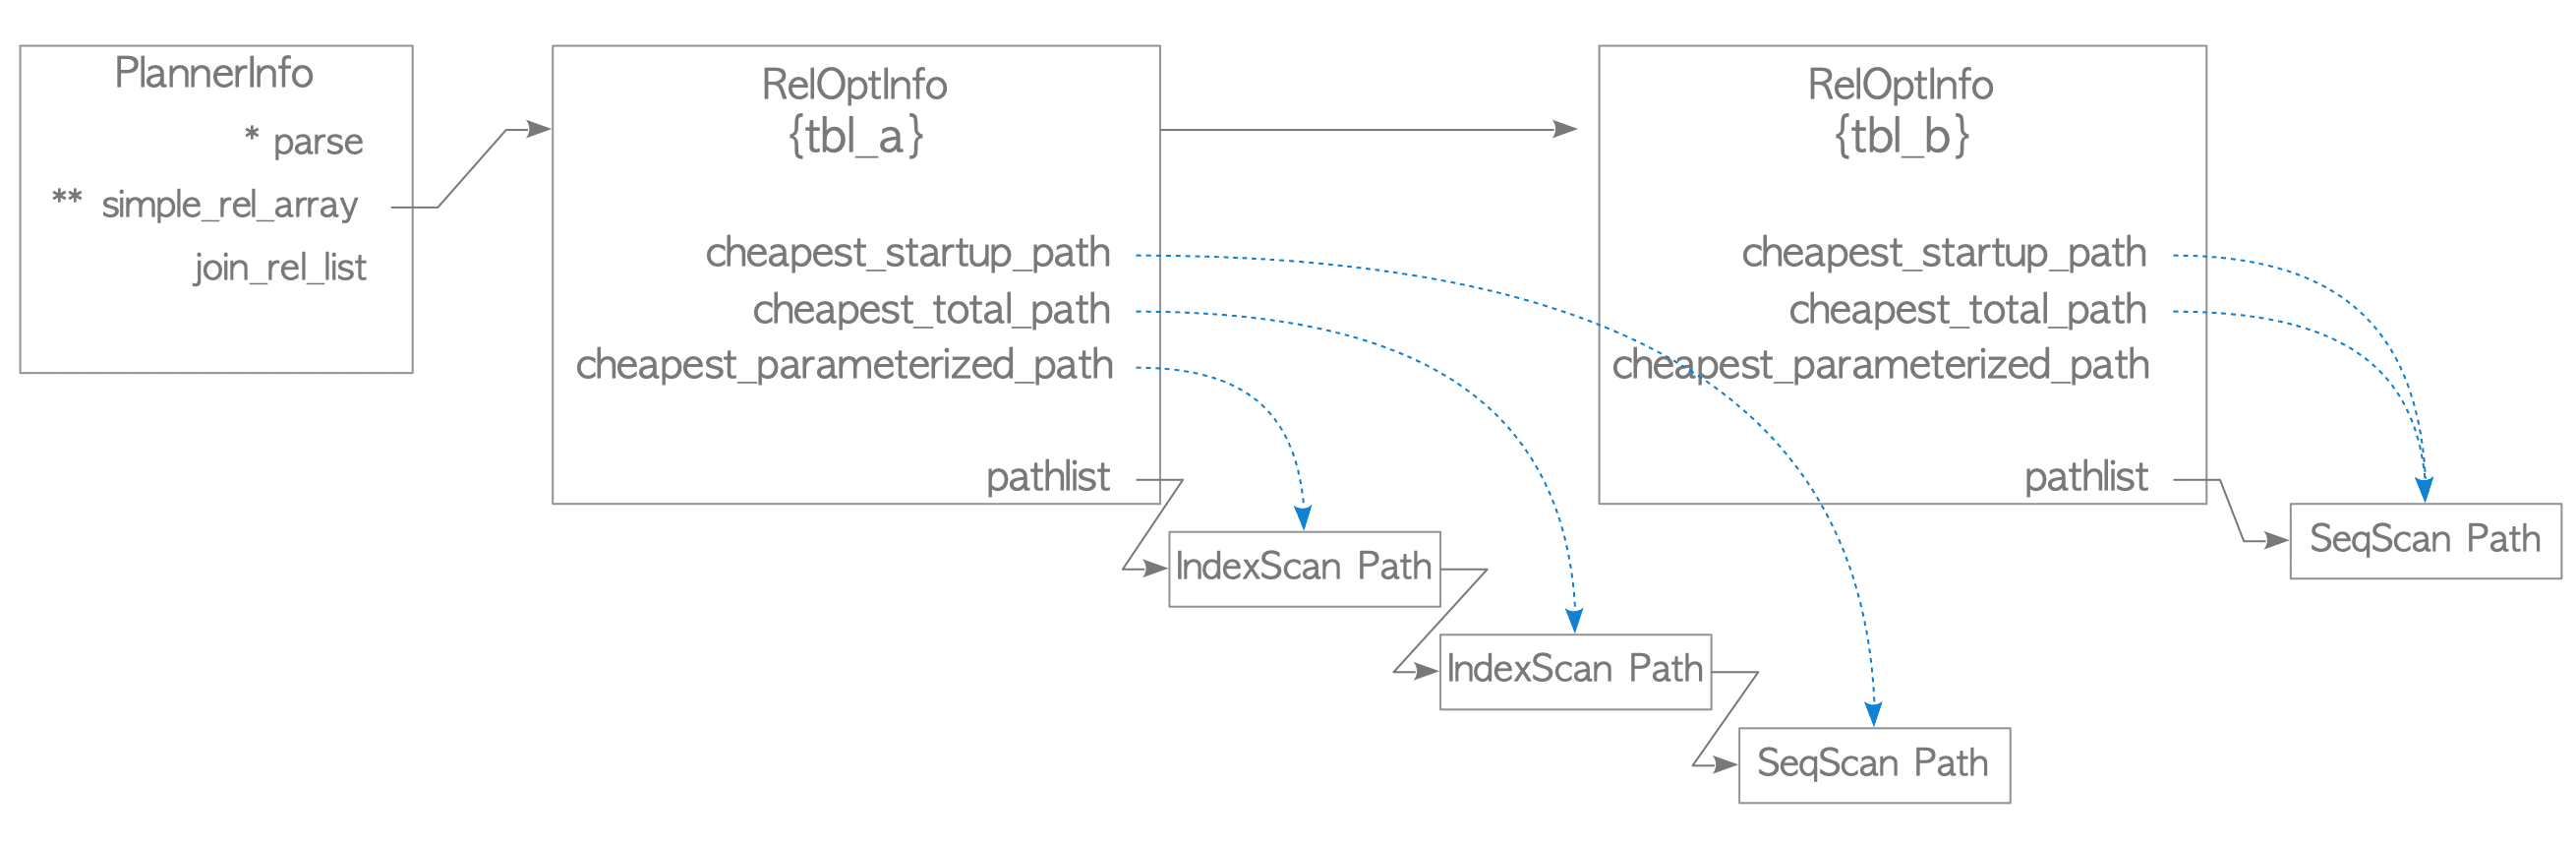

- tbl_a의 RelOptInfo에는 세 가지 액세스 경로가 있으며 RelOptInfo의 경로 목록에 추가.
- 각 액세스 경로는 가장 저렴한 시작(비용) 경로 , 가장 저렴한 전체(비용) 경로 , 가장 저렴한 매개변수화된(비용) 경로 등 가장 저렴한 비용 경로에 연결 .
- 가장 저렴한 시작 및 총 비용 경로는 명백하므로 가장 저렴한 매개변수화된 인덱스 스캔 경로의 비용을 설명.

- 플래너는 인덱스 중첩 루프 조인(그리고 드물게 외부 인덱스 스캔을 사용한 인덱스 병합 조인)에 대해 매개변수화된 경로의 사용을 고려.
- 가장 저렴한 매개변수화된 비용은 추정된 매개변수화된 경로 중 가장 저렴한 비용.

- tbl_b에는 관련 인덱스가 없기 때문에 tbl_b의 RelOptInfo에는 순차 스캔 액세스 경로만 있음.

**레벨 2에서 처리**

- 레벨 2에서는 RelOptInfo 구조가 생성되어 PlannerInfo의 Join_rel_list에 추가.
- 그런 다음 가능한 모든 조인 경로의 비용을 추정하고 총 비용이 가장 저렴한 최상의 액세스 경로를 선택.
-  RelOptInfo는 최상의 액세스 경로를 가장 저렴한 총 비용 경로로 저장

**수준 2에서 처리된 후의 PlannerInfo 및 RelOptInfo**

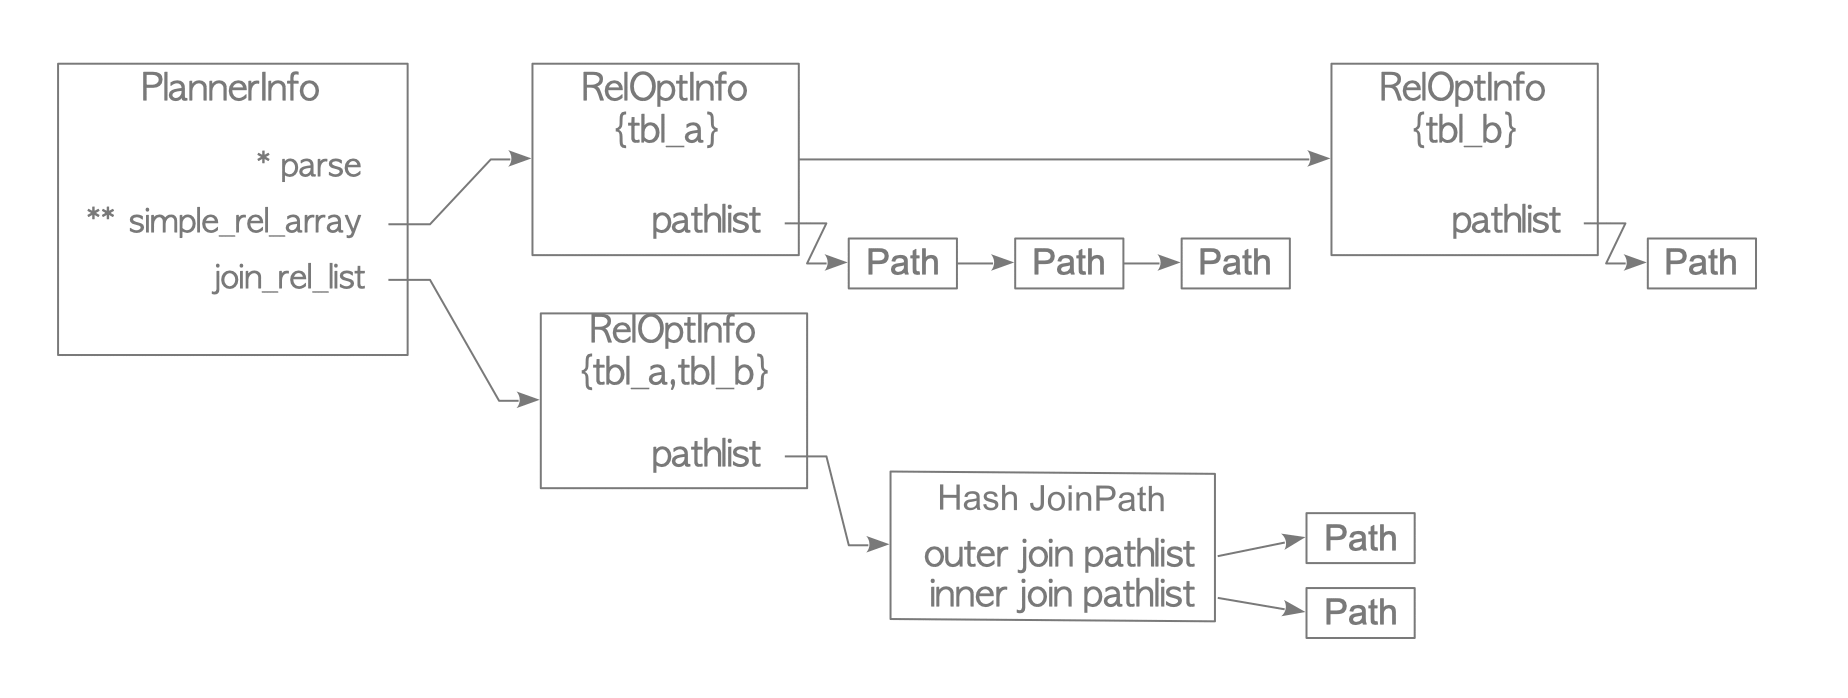

- 표는 예에서 조인 액세스 경로의 모든 조합을 보여줌.
- 이번 예시의 쿼리는 동등 조인 방식이므로 세 가지 조인 방식이 모두 추정.
- 편의를 위해 액세스 경로에 대한 몇 가지 표기법이 도입.

- SeqScanPath(table)은 테이블의 순차적 스캔 경로를 의미.

- Materialized->SeqScanPath(table)은 테이블의 구체화된 순차 스캔 경로를 의미.

- IndexScanPath(테이블, 속성)은 테이블의 속성에 따른 인덱스 스캔 경로를 의미.

- ParameterizedIndexScanPath(table, attribute1, attribute2)는 테이블의 attribute1에 의해 매개변수화된 인덱스 경로를 의미하며, 외부 테이블의 attribute2에 의해 매개변수화됨.

 **이 예에서 조인 액세스 경로의 모든 조합**

||외부 경로|	내부 경로|
|--|--|--|
|중첩된 루프 조인|
|1|	SeqScanPath(tbl_a)|	SeqScanPath(tbl_b)|
|2|	SeqScanPath(tbl_a)|	구체화됨->SeqScanPath(tbl_b)|	구체화된 중첩 루프 조인
|3|	IndexScanPath(tbl_a,id)|	SeqScanPath(tbl_b)|	외부 인덱스 스캔을 사용한 중첩 루프 조인
|4|	IndexScanPath(tbl_a,id)|	구체화됨->SeqScanPath(tbl_b)|	외부 인덱스 스캔을 사용한 구체화된 중첩 루프 조인
|5|	SeqScanPath(tbl_b)|	SeqScanPath(tbl_a)|
|6|	SeqScanPath(tbl_b)|	구체화됨->SeqScanPath(tbl_a)|	구체화된 중첩 루프 조인
|7|	SeqScanPath(tbl_b)|	ParametalizedIndexScanPath(tbl_a, id, tbl_b.id)|	인덱스 중첩 루프 조인
|병합 조인|
|1|	SeqScanPath(tbl_a)|	SeqScanPath(tbl_b)|
|2|	IndexScanPath(tbl_a,id)|	SeqScanPath(tbl_b)|	외부 인덱스 스캔을 사용한 병합 조인
|3|	SeqScanPath(tbl_b)|	SeqScanPath(tbl_a)|
|해시 조인|
|1|	SeqScanPath(tbl_a)|	SeqScanPath(tbl_b)|
|2|	SeqScanPath(tbl_b)|	SeqScanPath(tbl_a)|

- 예를 들어 중첩 루프 조인에서는 7개의 조인 경로가 추정.
  - 첫 번째는 외부 경로와 내부 경로가 각각 tbl_a와 tbl_b의 순차적 스캔 경로임을 나타냄.
  - 두 번째는 외부 경로가 tbl_a의 순차 스캔 경로이고 내부 경로가 tbl_b의 구체화된 순차 스캔 경로임을 나타냅니다.

- 플래너는 최종적으로 예상된 조인 경로 중에서 가장 저렴한 액세스 경로를 선택하고, 가장 저렴한 경로가 RelOptInfo {tbl_a,tbl_b}의 경로 목록에 추가

- 이 예에서는 아래 EXPLAIN 결과와 같이 플래너가 내부 및 외부 테이블이 tbl_b 및 tbl_c인 해시 조인을 선택.

```

testdb=# EXPLAIN  SELECT * FROM tbl_b AS b, tbl_c AS c WHERE c.id = b.id AND b.data < 400;
                              QUERY PLAN                              
----------------------------------------------------------------------
 Hash Join  (cost=90.50..277.00 rows=400 width=16)
   Hash Cond: (c.id = b.id)
   ->  Seq Scan on tbl_c c  (cost=0.00..145.00 rows=10000 width=8)
   ->  Hash  (cost=85.50..85.50 rows=400 width=8)
         ->  Seq Scan on tbl_b b  (cost=0.00..85.50 rows=400 width=8)
               Filter: (data < 400)
(6 rows)
```

# **삼중 테이블 쿼리의 가장 저렴한 경로 얻기**

- 세 개의 테이블이 포함된 쿼리의 가장 저렴한 경로를 얻는 방법.

```
testdb=# \d tbl_a
     Table "public.tbl_a"
 Column |  Type   | Modifiers
--------+---------+-----------
 id     | integer |
 data   | integer |

testdb=# \d tbl_b
     Table "public.tbl_b"
 Column |  Type   | Modifiers
--------+---------+-----------
 id     | integer |
 data   | integer |

testdb=# \d tbl_c
     Table "public.tbl_c"
 Column |  Type   | Modifiers
--------+---------+-----------
 id     | integer | not null
 data   | integer |
Indexes:
    "tbl_c_pkey" PRIMARY KEY, btree (id)

testdb=# SELECT * FROM tbl_a AS a, tbl_b AS b, tbl_c AS c
testdb-#                WHERE a.id = b.id AND b.id = c.id AND a.data < 40;
```

- 수준 1:
  - 플래너는 모든 테이블의 가장 저렴한 경로를 추정하고 이 정보를 해당 RelOptInfo 개체({tbl_a}, {tbl_b} 및 {tbl_c})에 저장.

- 수준 2:
  - 플래너는 세 테이블 쌍의 모든 조합을 선택하고 각 조합에 대해 가장 저렴한 경로를 추정. 그런 다음 플래너는 해당 RelOptInfo 개체({tbl_a, tbl_b}, {tbl_b, tbl_c} 및 {tbl_a, tbl_c})에 정보를 저장.

- 수준 3:
  - 플래너는 이미 획득한 RelOptInfo 객체를 사용하여 최종적으로 가장 저렴한 경로를 얻음.

- 보다 정확하게는 플래너는 RelOptInfo 개체의 세 가지 조합인 {tbl_a, {tbl_b, tbl_c}}, {tbl_b, {tbl_a, tbl_c}} 및 {tbl_c, {tbl_a, tbl_b}}를 고려.

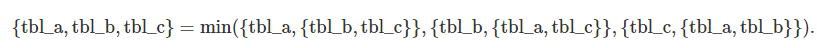

- 그런 다음 플래너는 가능한 모든 조인 경로의 비용을 추정.

- RelOptInfo onject {tbl_c, {tbl_a, tbl_b}}에서 플래너는 tbl_c의 모든 조합과 내부 및 외부 테이블이 각각 tbl_a 및 tbl_b인 해시 조인인 {tbl_a, tbl_b}의 가장 저렴한 경로를 추정

- 예상 조인 경로에는 이전 하위 섹션에 표시된 것과 같은 세 가지 종류의 조인 경로와 해당 변형, 즉 중첩 루프 조인과 변형, 병합 조인과 변형, 해시 조인이 포함.

- 플래너는 RelOptInfo 객체인 {tbl_a, {tbl_b, tbl_c}}와 {tbl_b, {tbl_a, tbl_c}}를 동일한 방식으로 처리하고, 최종적으로 추정된 모든 경로 중에서 가장 저렴한 접근 경로를 선택.

- 이 쿼리의 EXPLAIN 명령 결과는 다음과 같음.

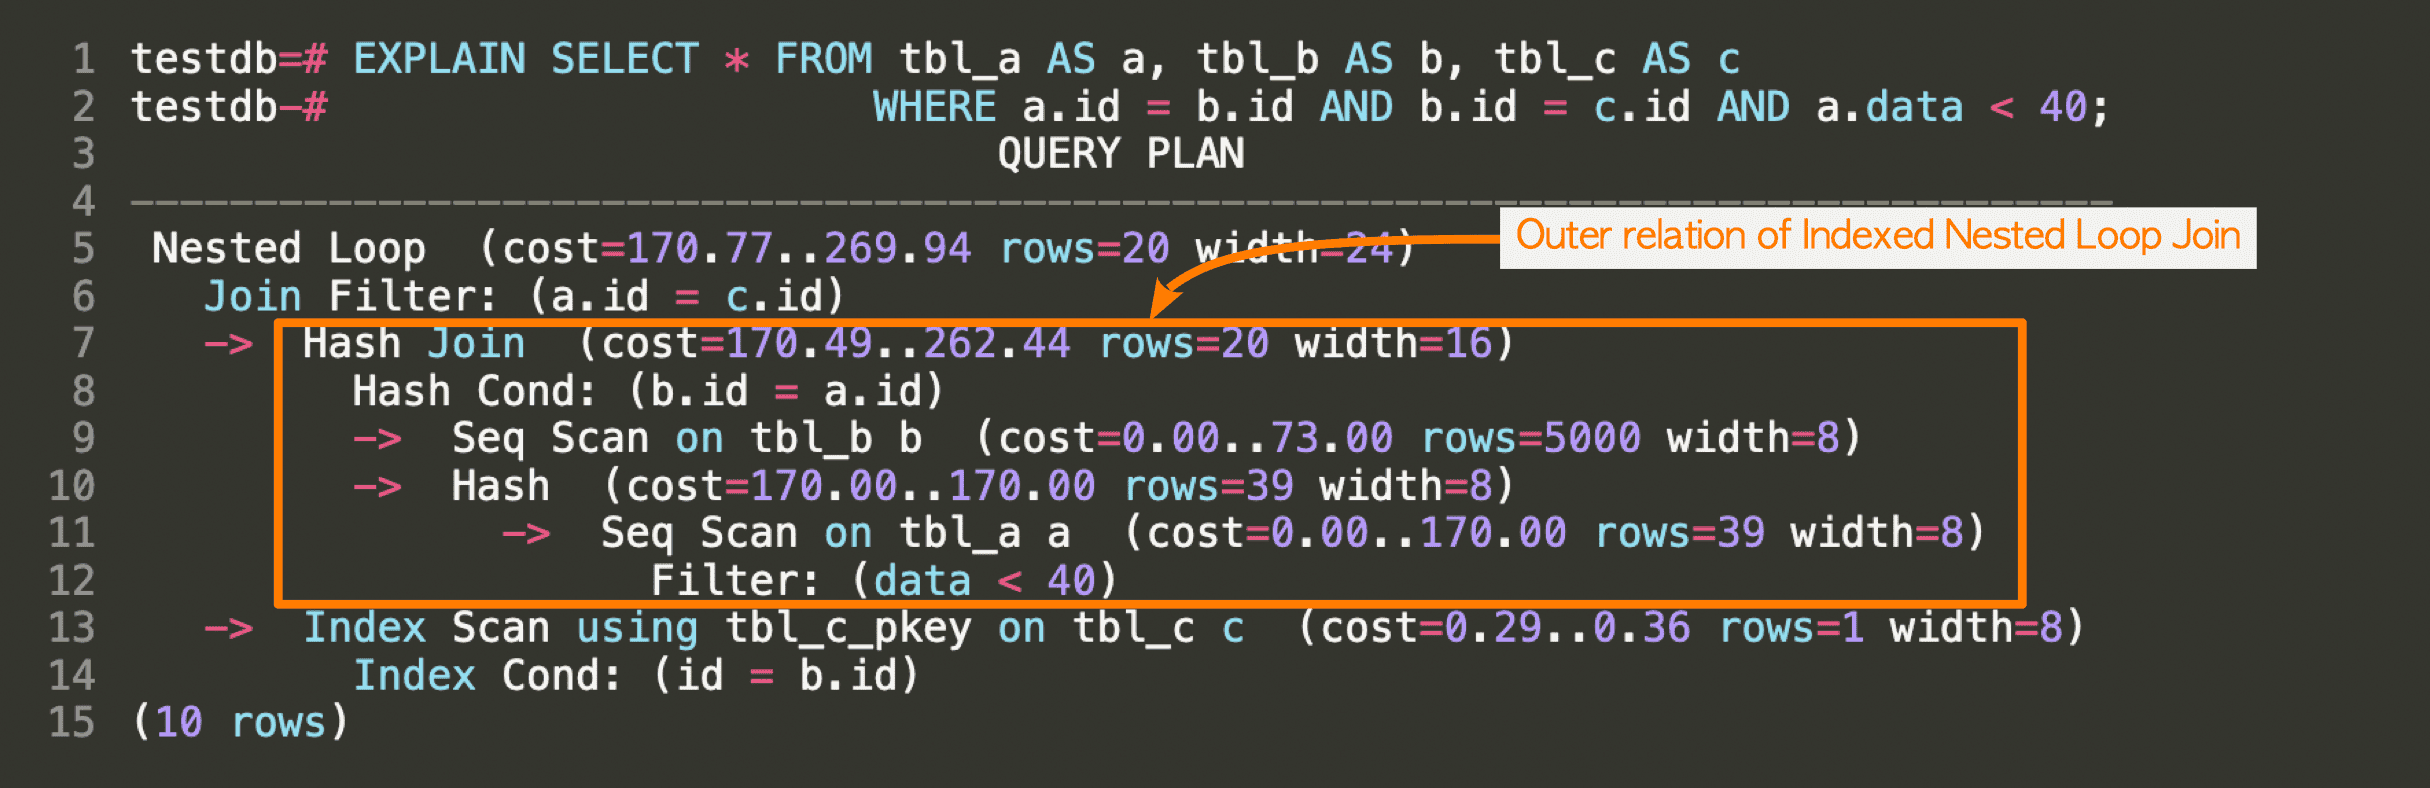

- 가장 바깥쪽 조인은 인덱스 중첩 루프 조인(라인 5).
- 내부 매개변수화된 인덱스 스캔은 13행에 표시되며 외부 관계는 내부 및 외부 테이블이 각각 tbl_b 및 tbl_a인 해시 조인의 결과(7-12행)
- . 따라서 실행자는 먼저 tbl_a와 tbl_b의 해시 조인을 실행한 다음 인덱스 중첩 루프 조인을 실행.